In [460]:
import sympy as sp
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pylab as plt
from tqdm import tqdm

In [461]:
# State
S, L, I, A = sp.symbols('S L I A')
state = [S, L, I, A]

# Control
nu = sp.symbols('nu')


# Parmaeters
beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q = sp.symbols('beta sigma kappa alpha tau p eta epsilon q delta P Q')
params = [beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q]

In [462]:
# Adjoints
l_S, l_L, l_I, l_A = sp.symbols('lambda_S lambda_L lambda_I lambda_A')
adjoint = [l_S, l_L, l_I, l_A]
l = sp.Matrix([l_S, l_L, l_I, l_A])
print(l)

f = P * I + Q * nu**2
g = sp.Matrix([- beta * (1-sigma) * S * (epsilon * L + (1 - q) * I + delta * A) - nu * S,
                beta * (1-sigma) * S * (epsilon * L + (1 - q) * I + delta * A) - kappa * L,
                p * kappa * L - alpha * I - tau * I,
                (1 - p) * kappa * L  - eta * A])
H = sp.Matrix([f + l.dot(g)])
print(g)
print(H)

Matrix([[lambda_S], [lambda_L], [lambda_I], [lambda_A]])
Matrix([[-S*beta*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon) - S*nu], [-L*kappa + S*beta*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon)], [-I*alpha - I*tau + L*kappa*p], [-A*eta + L*kappa*(1 - p)]])
Matrix([[I*P + Q*nu**2 + lambda_A*(-A*eta + L*kappa*(1 - p)) + lambda_I*(-I*alpha - I*tau + L*kappa*p) + lambda_L*(-L*kappa + S*beta*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon)) + lambda_S*(-S*beta*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon) - S*nu)]])


In [463]:
# State에 대해 미분
dHdx = H.jacobian(state)
# Lambda에 대해 미분 --> 원래 ODE
dHdl = H.jacobian(adjoint)
# nu에 대해 미분
dHdnu = H.jacobian([nu])
print(dHdx)
print(dHdl)
print(dHdnu)

Matrix([[beta*lambda_L*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon) + lambda_S*(-beta*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon) - nu), -S*beta*epsilon*lambda_S*(1 - sigma) + kappa*lambda_A*(1 - p) + kappa*lambda_I*p + lambda_L*(S*beta*epsilon*(1 - sigma) - kappa), P + S*beta*lambda_L*(1 - q)*(1 - sigma) - S*beta*lambda_S*(1 - q)*(1 - sigma) + lambda_I*(-alpha - tau), S*beta*delta*lambda_L*(1 - sigma) - S*beta*delta*lambda_S*(1 - sigma) - eta*lambda_A]])
Matrix([[-S*beta*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon) - S*nu, -L*kappa + S*beta*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon), -I*alpha - I*tau + L*kappa*p, -A*eta + L*kappa*(1 - p)]])
Matrix([[2*Q*nu - S*lambda_S]])


In [464]:
# Automation
# 구문: sp.lambdify(변수, 표현식, 라이브러리)
cost_fn = sp.lambdify([*state, *params, nu], f)
dHdx_fn = sp.lambdify([*adjoint, *state, *params, nu], dHdx)
# 원래 ODE
dHdl_fn = sp.lambdify([*adjoint, *state, *params, nu], dHdl)
dHdnu_fn = sp.lambdify([*adjoint, *state, *params, nu], dHdnu)

In [465]:
# ODE Systems
def state_de(y, t, params, nu_interp):
    return dHdl_fn(*(y*0), *y, *params, nu_interp(t))[0]

def adjoint_de(y, t, x_interp, params, nu_interp):
    val = -dHdx_fn(*y, *x_interp(t), *params, nu_interp(t))[0]
    return val

In [466]:
t0 = 0
tf = 300
S0 = 1E6
L0 = 0
I0 = 1
A0 = 0
sigma = 0 
kappa = 0.526
alpha = 0.244
tau = 0
p = 0.667
eta = 0.244
epsilon = 0
q = 0.5
delta = 1
R0 = 1.9847
beta = 5.27e-07
#beta = R0/(S0 * ((epsilon / kappa) + ((1 - q)*p/alpha) + (delta*(1-p)/eta)))
P, Q = 1, 1

params = [beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q]
print(params)

[7.265818454613654e-07, 0, 0.526, 0.244, 0, 0.667, 0.244, 0, 0.5, 1, 1, 1]


In [467]:
# Initial
y0 = np.array([S0, L0, I0, A0])
state_dim = len(y0)
t = np.linspace(t0,tf, 301)
dt = t[1] - t[0]
nu0 = np.ones_like(t)
wonu = np.zeros_like(t)

MaxIter = 10000
learn_rate = 0.001
old_cost = 1E8


[[1.00000000e+06 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [9.99999665e+05 2.58671650e-01 8.29994330e-01 2.32184847e-02]
 [9.99999346e+05 4.01476938e-01 7.55668385e-01 7.08014473e-02]
 ...
 [2.07411026e+05 9.95913554e-06 2.71589855e-05 1.35591337e-05]
 [2.07411026e+05 8.87256642e-06 2.41957456e-05 1.20797351e-05]
 [2.07411026e+05 7.90811880e-06 2.15655255e-05 1.07665967e-05]]


<Figure size 800x450 with 0 Axes>

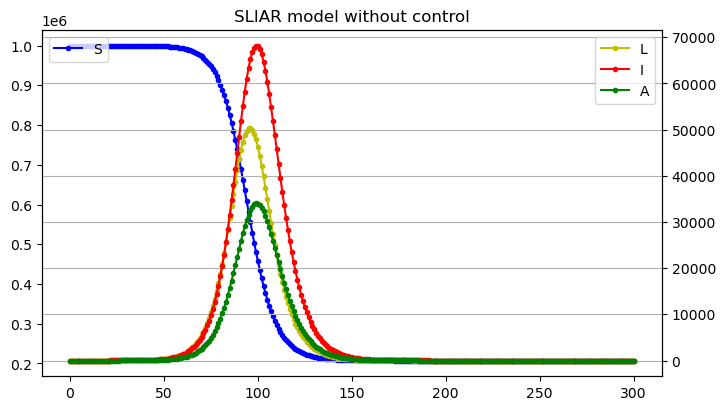

In [468]:
nu_intp0 = lambda tc: np.interp(tc, t, wonu)
sol0 = odeint(state_de, y0, t, args=(params, nu_intp0))
print(sol0)

import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (8, 4.5)

plt.clf()
fig, ax1 = plt.subplots()
ax1.plot(t, sol0[:,0], '.-b', label = 'S')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(t, sol0[:,1], '.-y', label = 'L')
ax2.plot(t, sol0[:,2], '.-r', label = 'I')
ax2.plot(t, sol0[:,3], '.-g', label = 'A')
ax2.legend(loc='lower right')
plt.grid()
plt.legend()
plt.title('SLIAR model without control')
plt.xlabel('day')
plt.savefig('SLIAR_wo_control_adj.png', dpi=300)
plt.show(block=False)

  0%|          | 0/10001 [00:00<?, ?it/s]

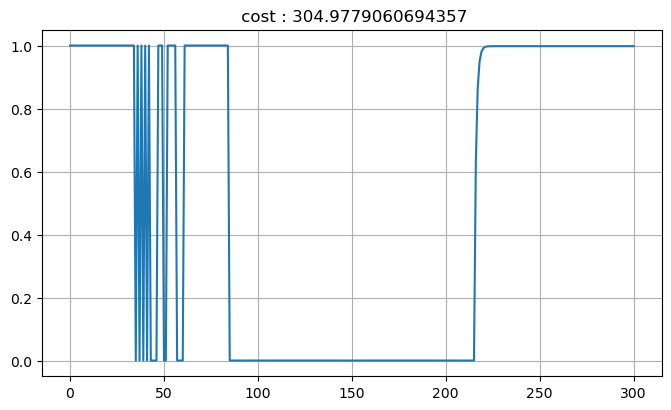

  0%|          | 1/10001 [00:00<50:48,  3.28it/s]

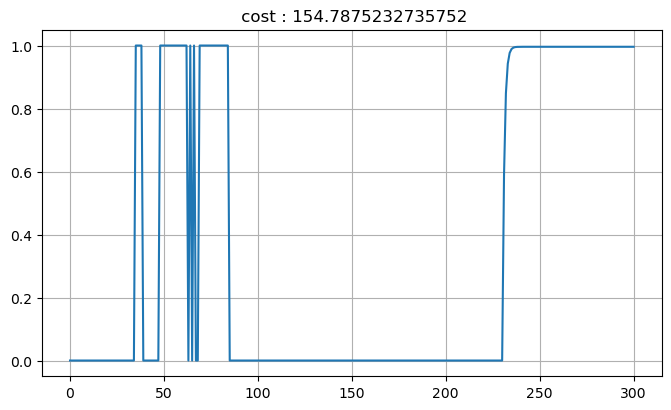

  0%|          | 2/10001 [00:00<48:17,  3.45it/s]

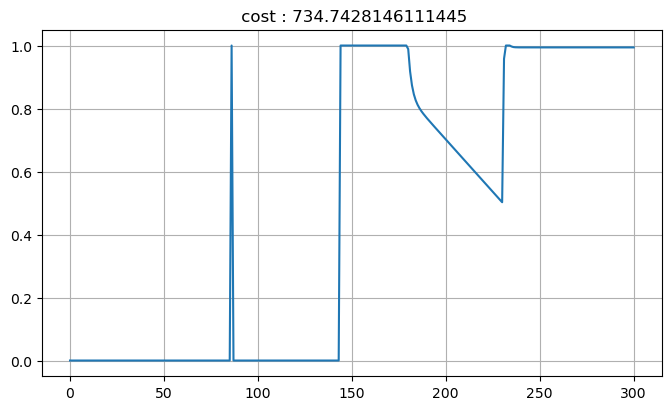

  0%|          | 3/10001 [00:00<52:56,  3.15it/s]

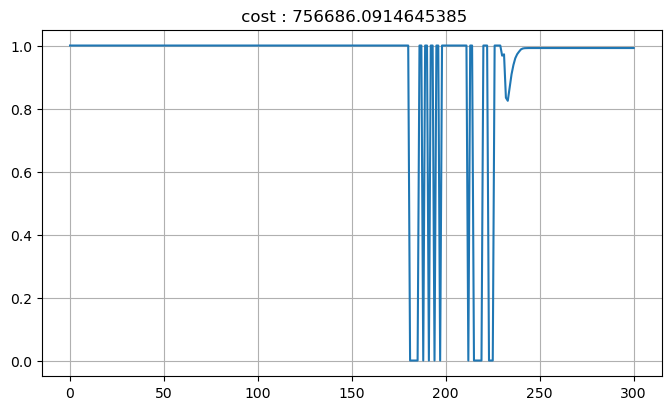

  0%|          | 4/10001 [00:01<1:01:11,  2.72it/s]

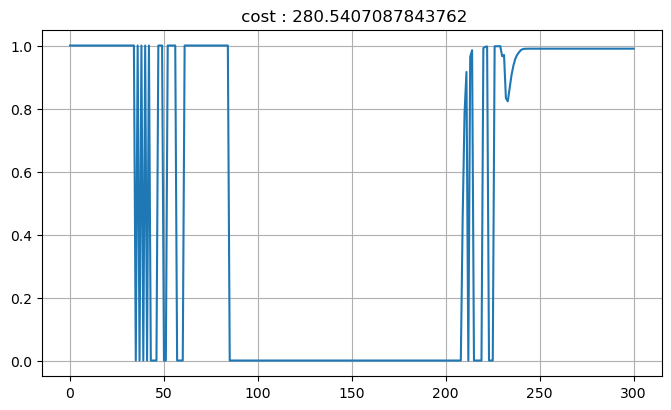

  0%|          | 5/10001 [00:01<1:00:20,  2.76it/s]

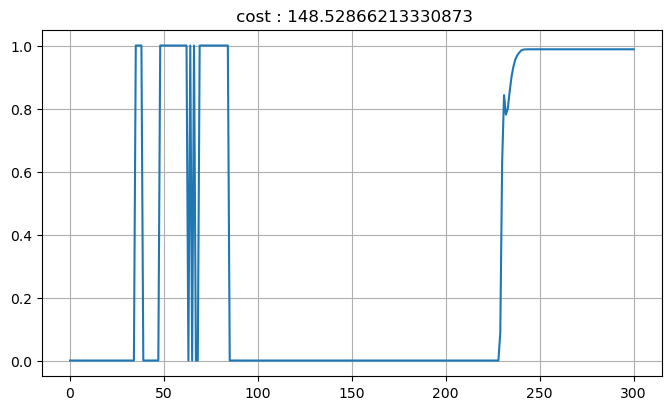

  0%|          | 6/10001 [00:02<57:08,  2.92it/s]  

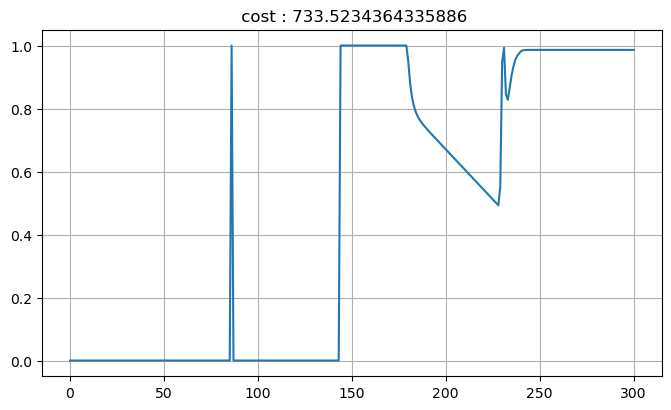

  0%|          | 7/10001 [00:02<58:08,  2.87it/s]

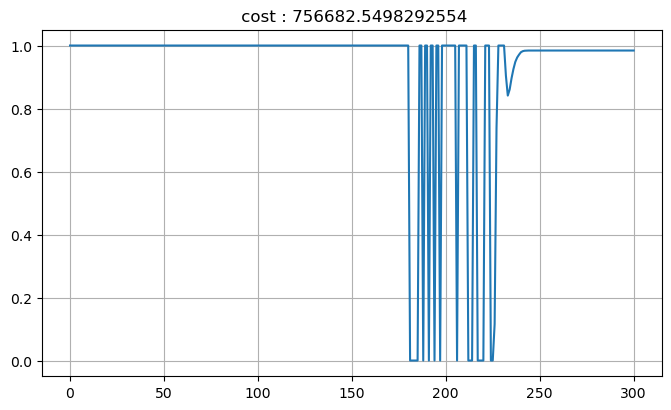

  0%|          | 8/10001 [00:02<1:03:22,  2.63it/s]

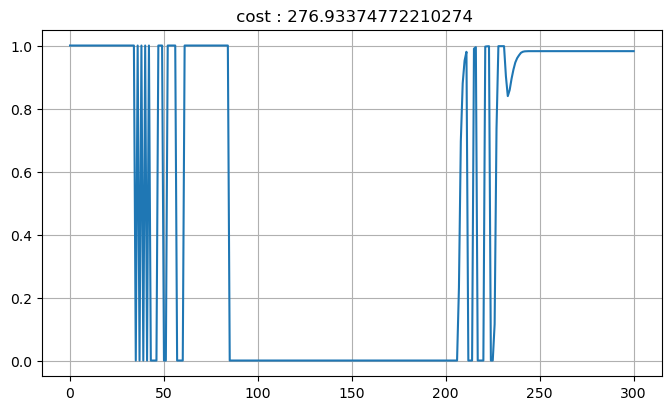

  0%|          | 9/10001 [00:03<1:02:18,  2.67it/s]

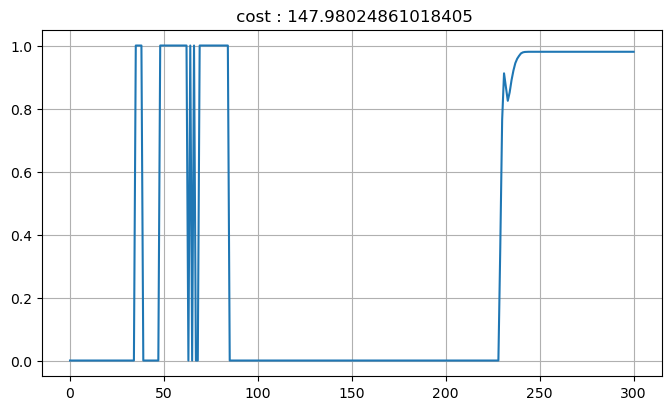

  0%|          | 10/10001 [00:03<59:05,  2.82it/s] 

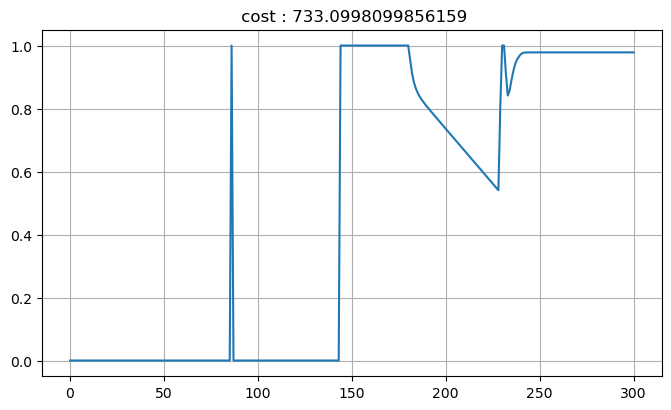

  0%|          | 11/10001 [00:03<59:33,  2.80it/s]

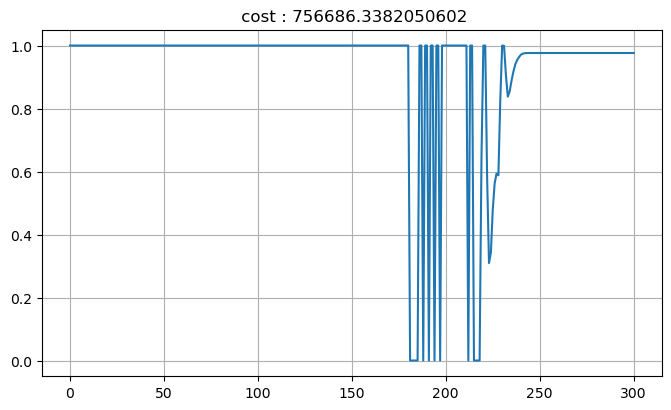

  0%|          | 12/10001 [00:04<1:03:32,  2.62it/s]

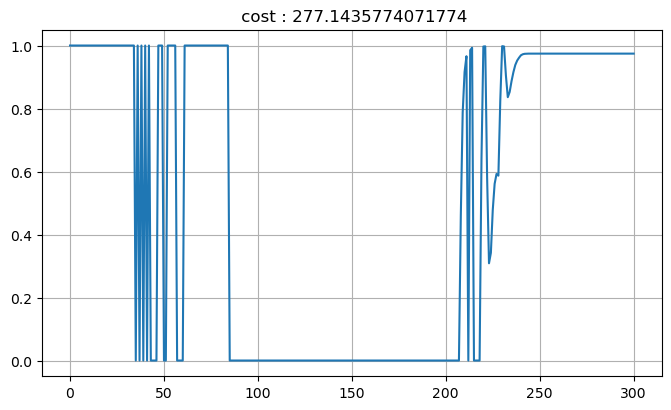

  0%|          | 13/10001 [00:04<1:02:28,  2.66it/s]

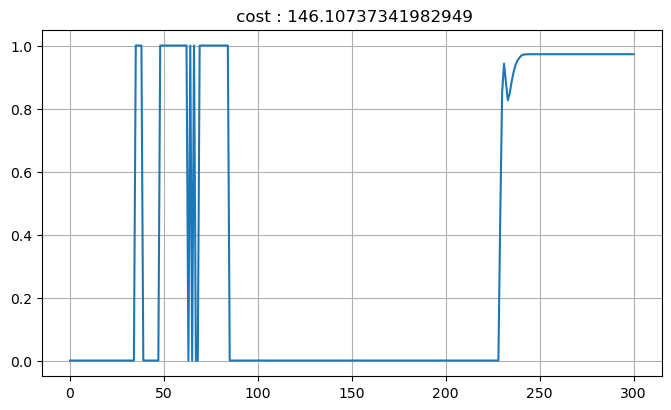

  0%|          | 14/10001 [00:04<59:22,  2.80it/s]  

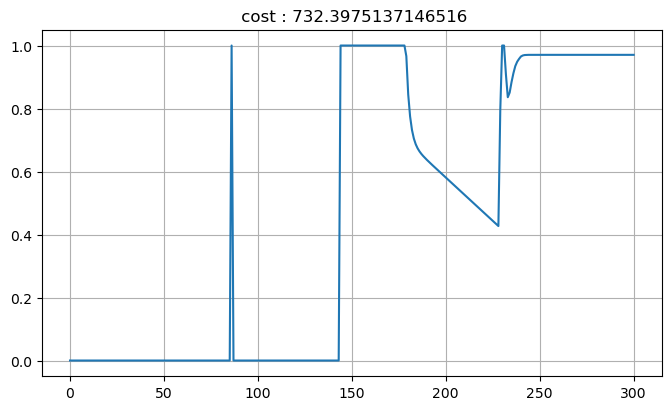

  0%|          | 15/10001 [00:05<59:46,  2.78it/s]

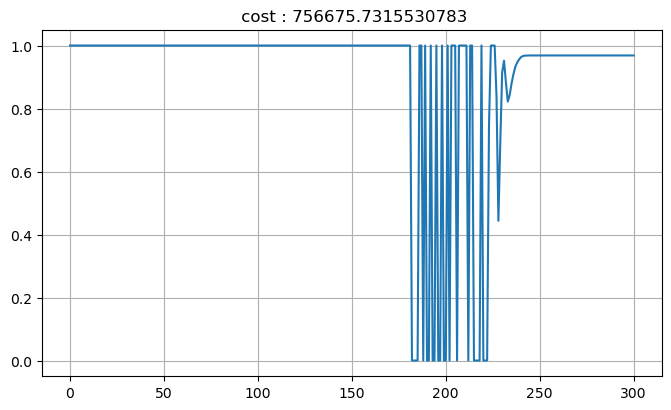

  0%|          | 16/10001 [00:05<1:04:20,  2.59it/s]

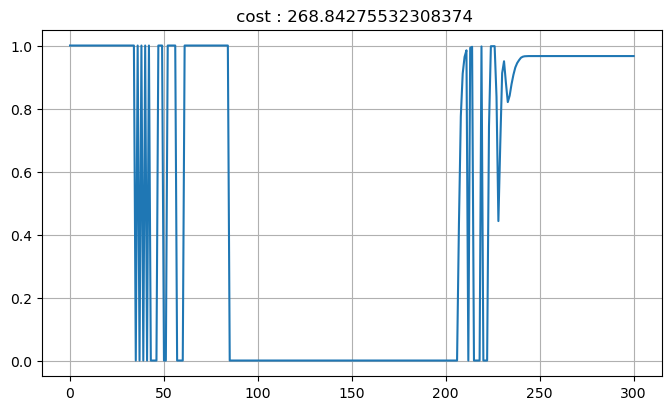

  0%|          | 17/10001 [00:06<1:00:45,  2.74it/s]


KeyboardInterrupt: 

In [469]:
for it in tqdm(range(MaxIter+1)):
    # State
    nu_intp = lambda tc: np.interp(tc, t, nu0)
    sol = odeint(state_de, y0, t, args=(params, nu_intp))

    # Cost
    state_mid = [(ss[1:] + ss[:-1]) / 2. for ss in np.hsplit(sol, state_dim)]
    nu_mid = (nu0[1:] + nu0[:-1]) / 2.
    cost = np.sum ( dt * cost_fn(*state_mid, *params, np.expand_dims(nu_mid, 1)) )

    # Adjoint
    nu_intp = lambda tc: np.interp(tf - tc, t, nu0)
    x_intp = lambda tc: np.array([np.interp(tf - tc, t, sol[:, k]) for k in range(state_dim)])
    y_T = y0 * 0
    l_sol = odeint(adjoint_de, y_T, t, args=(x_intp, params, nu_intp))
    l_sol = np.flipud(l_sol)

    # Simple Gradient
    l_sols = [l_sol[:, k] for k in range(state_dim)]
    sols = [sol[:, k] for k in range(state_dim)]

    Hnu = dHdnu_fn(*l_sols, *sols, *params, nu0)[0][0]
    # maximum nu = 0.01
    nu1 = np.clip(nu0 - learn_rate * Hnu , 0, 1)
    if old_cost < cost:
        learn_rate = learn_rate / 10 # simple adaptive learning rate

    # Convergence
    if np.abs(old_cost - cost) / learn_rate  <= 1E-7:
        break

    old_cost = cost
    nu0 = nu1

    plt.plot(t, nu0)
    plt.grid()
    plt.title(' cost : '+str(old_cost))
    #plt.savefig('control_nu'+str(learn_rate)+'.png', dpi=300)
    plt.show()
    

import matplotlib.pylab as plt
plt.clf()
fig, ax1 = plt.subplots()
ax1.plot(t, sol[:,0], '.-b', label = 'S')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(t, sol[:,1], '.-y', label = 'L')
ax2.plot(t, sol[:,2], '.-r', label = 'I')
ax2.plot(t, sol[:,3], '.-g', label = 'A')
ax2.legend(loc='lower right')
plt.grid()
plt.legend()
plt.title('SLIAR model with control'+' cost : '+str(old_cost))
plt.xlabel('day')
#plt.savefig('SLIAR_w_control_adj'+str(learn_rate)+'.png', dpi=300)
plt.show(block=False)

plt.plot(t, nu0)
plt.grid()
#plt.savefig('control_nu'+str(learn_rate)+'.png', dpi=300)
plt.show()

<Figure size 800x450 with 0 Axes>

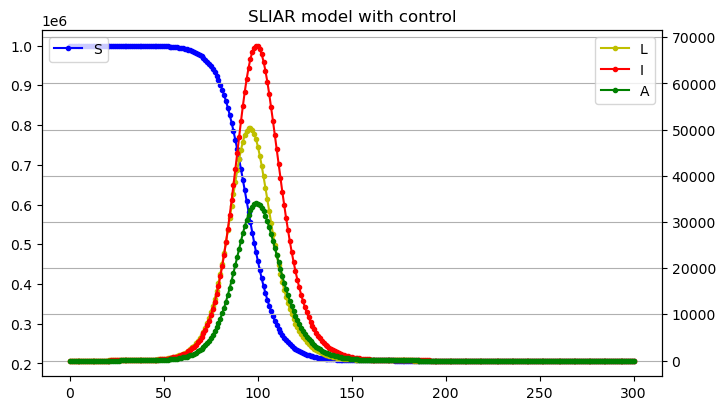

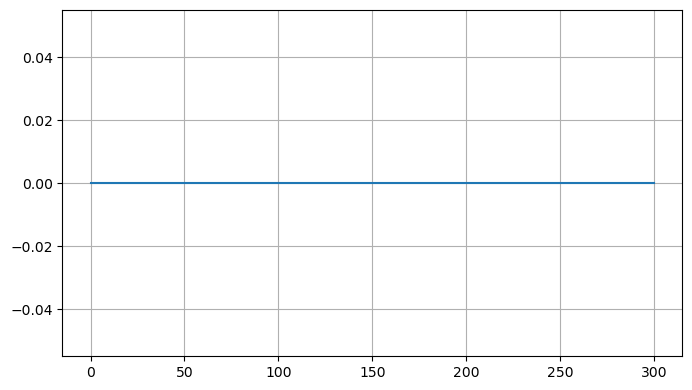

In [ ]:
import matplotlib.pylab as plt
plt.clf()
fig, ax1 = plt.subplots()
ax1.plot(t, sol[:,0], '.-b', label = 'S')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(t, sol[:,1], '.-y', label = 'L')
ax2.plot(t, sol[:,2], '.-r', label = 'I')
ax2.plot(t, sol[:,3], '.-g', label = 'A')
ax2.legend(loc='lower right')
plt.grid()
plt.legend()
plt.title('SLIAR model with control')
plt.xlabel('day')
plt.savefig('SLIAR_w_control_adj.png', dpi=300)
plt.show(block=False)

plt.plot(t, nu0)
plt.grid()
plt.show()